In [ ]:
# Install Dependencies

# !pip install spotipy pandas scikit-learn matplotlib seaborn kneed

In [1]:
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from kneed import KneeLocator
sns.set()

## Spotipy Credentials and API Calls

In [3]:
username = 'your_username'
client_id = 'your_client_id'
client_secret = 'your_client_secret'
redirect_uri = 'http://localhost/'      # Set as redirect uri in Spotify Developer Dashboard for your app

In [3]:
# Initialize Spotify API token
token = util.prompt_for_user_token(username, scope='playlist-read-private', client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
sp = spotipy.Spotify(auth=token)

In [4]:
# A function to extract track names and URIs from a playlist
def get_playlist_info(username, playlist_uri):
    # initialize vars
    offset = 0
    tracks, uris, names, artists = [], [], [], []

    # get playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = sp.user_playlist(username, playlist_id)['name']

    # get all tracks in given playlist (max limit is 100 at a time --> use offset)
    while True:
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] is not None:
            offset += 100
        else:
            break
        
    # get track metadata
    for track in tracks:
        names.append(track['track']['name'])
        artists.append(track['track']['artists'][0]['name'])
        uris.append(track['track']['uri'])
    
    return playlist_name, names, artists, uris

In [5]:
# Extract features from each track in a playlist
def get_features_for_playlist(df, username, uri):
  
    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)
    
    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):
        # print(json.dumps(track_uri, indent=4))              
        # ^ DEBUG STATEMENT ^
        
        # access audio features for given track URI via spotipy 
        audio_features = sp.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [audio_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

In [6]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'time_signature', 'key', 'mode', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])

Importing Spotify playlist

In [7]:
df = get_features_for_playlist(df, username, 'spotify:playlist:3uFoFOG2iR7r3DubKjeqVK')
df


,name,artist,track_URI,time_signature,key,mode,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Talibans,Byron Messia,spotify:track:0TTOsyDKykWhCh3qDd9wMY,4,4,0,0.571000,0.929,0.430,0.000000,0.1050,-9.338,0.2060,102.991,0.498,ATSMC
1,Gbona,Burna Boy,spotify:track:7rpWDu9GPlLxbLorYKVys7,4,4,0,0.564000,0.798,0.813,0.000142,0.1080,-5.869,0.1620,93.912,0.942,ATSMC
2,"PAMI (feat. Wizkid, Adekunle Gold & Omah Lay)",DJ Tunez,spotify:track:6iC4xfqow6iAsRhPh5IrWz,4,3,0,0.625000,0.755,0.645,0.000006,0.1970,-6.933,0.0944,99.889,0.695,ATSMC
3,Pull Up,Koffee,spotify:track:6eydzKn9vLC57U9iToAwJD,4,7,1,0.316000,0.810,0.604,0.051400,0.0944,-3.296,0.0904,102.937,0.646,ATSMC
4,Ginger (feat. Burna Boy),Wizkid,spotify:track:51mLQ3w7yR7vjdSTFLWaY5,4,4,0,0.103000,0.545,0.749,0.000000,0.2320,-6.621,0.1530,100.503,0.681,ATSMC
5,Blood and Thunder,Mastodon,spotify:track:3jagGO7eHHuaD53ibehkux,4,2,1,0.000009,0.364,0.935,0.729000,0.0317,-6.548,0.0724,92.717,0.478,ATSMC
6,Laid to Rest,Lamb of God,spotify:track:1yc53HK08sDab7PDFgnLWk,3,10,0,0.000293,0.366,0.956,0.004470,0.4490,-3.725,0.1080,104.016,0.159,ATSMC
7,Re-Crucified,Revocation,spotify:track:2bJGjDcYtSPt2YVZVh3G95,4,10,0,0.000113,0.499,0.992,0.000265,0.2120,-4.876,0.1390,111.518,0.074,ATSMC
8,Lifestalker,Cattle Decapitation,spotify:track:7Apb2x5qHdEEO7SG8f5uH9,4,6,1,0.000019,0.323,0.986,0.568000,0.3080,-3.612,0.1700,115.107,0.224,ATSMC
9,As Grace Descends,Suffocation,spotify:track:6mkGQ9tHzVUVQidmt6gM3y,4,1,1,0.000009,0.417,0.982,0.506000,0.3720,-4.609,0.1800,105.962,0.200,ATSMC


Isolate the features we want to use for clustering

In [8]:
non_features = ['name', 'artist', 'track_URI', 'time_signature', 'key', 'mode', 'playlist']
track_info = df[non_features]
df_X = df.drop(columns=non_features)
df_X

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.571000,0.929,0.430,0.000000,0.1050,-9.338,0.2060,102.991,0.498
1,0.564000,0.798,0.813,0.000142,0.1080,-5.869,0.1620,93.912,0.942
2,0.625000,0.755,0.645,0.000006,0.1970,-6.933,0.0944,99.889,0.695
3,0.316000,0.810,0.604,0.051400,0.0944,-3.296,0.0904,102.937,0.646
4,0.103000,0.545,0.749,0.000000,0.2320,-6.621,0.1530,100.503,0.681
5,0.000009,0.364,0.935,0.729000,0.0317,-6.548,0.0724,92.717,0.478
6,0.000293,0.366,0.956,0.004470,0.4490,-3.725,0.1080,104.016,0.159
7,0.000113,0.499,0.992,0.000265,0.2120,-4.876,0.1390,111.518,0.074
8,0.000019,0.323,0.986,0.568000,0.3080,-3.612,0.1700,115.107,0.224
9,0.000009,0.417,0.982,0.506000,0.3720,-4.609,0.1800,105.962,0.200


Scaling the Data

In [9]:
scaler = StandardScaler()
X_std = scaler.fit_transform(df_X)

## K-Means Clustering

Finding the elbow point of the WCSS (within cluster sum of squares) curve 

In [ ]:
maxclusters = 10
wcss = []
for i in range(1, maxclusters+1):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_std)
    wcss.append(kmeans.inertia_)

Finding Optimal Number of Clusters

Optimal number of clusters 3


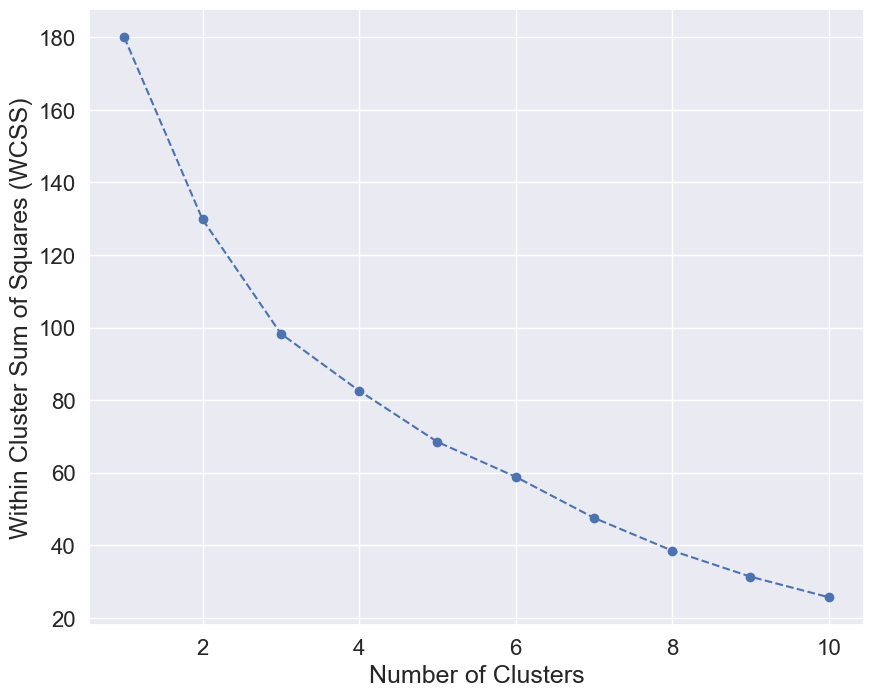

In [11]:
n_clusters = KneeLocator([i for i in range(1, maxclusters+1)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)
    
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, maxclusters+1), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Clustering using the optimal k found

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
cluster = kmeans.fit_predict(X_std)


Analysis

In [16]:
nf = ["name", "artist"]  # Add other column names as needed
df_cl = df.loc[:, nf].copy()
df_cl['cluster'] = cluster
df_cl

,name,artist,cluster
0,Talibans,Byron Messia,2
1,Gbona,Burna Boy,2
2,"PAMI (feat. Wizkid, Adekunle Gold & Omah Lay)",DJ Tunez,2
3,Pull Up,Koffee,2
4,Ginger (feat. Burna Boy),Wizkid,1
5,Blood and Thunder,Mastodon,0
6,Laid to Rest,Lamb of God,0
7,Re-Crucified,Revocation,0
8,Lifestalker,Cattle Decapitation,0
9,As Grace Descends,Suffocation,0
